# Advanced RNNs

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/logo.png" width=150>

In this notebook we're going to cover some advanced topics related to RNNs.

1. Conditioned hidden state
2. Char-level embeddings
3. Encoder and decoder
4. Attentional mechanisms
5. Implementation




# Set up

In [0]:
!pip3 install http://download.pytorch.org/whl/cpu/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [0]:
import os
from argparse import Namespace
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import torch

In [0]:
# Set Numpy and PyTorch seeds
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [0]:
# Arguments
args = Namespace(
    seed=1234,
    cuda=False,
    shuffle=True
)

# Set seeds
set_seeds(seed=args.seed, cuda=args.cuda)

# Conditioned RNNs

Conditioning an RNN is to add extra information that will be helpful towards a prediction. We can encode (embed it) this information and feed it along with the sequential input into our model. For example, suppose in our document classificaiton example in the previous notebook, we knew the publisher of each news article (NYTimes, ESPN, etc.). We could have encoded that information to help with the prediction. There are several different ways of creating a conditioned RNN.

**Note**: If the conditioning information is novel for each input in the sequence, just concatenate it along with each time step's input.

1. Make the initial hidden state the encoded information instead of using the initial zerod hidden state. Make sure that the size of the encoded information is the same as the hidden state for the RNN.


**IMAGE with only h_0 being the condition embedding.**

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
# Arguments
args = Namespace(
    batch_size=4,
    condition_vocab_size=3, # vocabulary for condition possibilities
    embedding_dim=100,
    hidden_dim=100,
    num_layers=1,
    bidirectional=False,
)

In [187]:
# Initialize hidden state
condition = torch.LongTensor([0, 2, 1, 2]) # batch size of 4 with a vocab size of 3
condition_embeddings = nn.Embedding(embedding_dim=args.embedding_dim, # should be same as RNN hidden dim
                                    num_embeddings=args.condition_vocab_size, # of unique conditions
                                   )
num_directions = 1
if args.bidirectional:
    num_directions = 2
hidden_t = condition_embeddings(condition).unsqueeze(0).repeat(
    args.num_layers * num_directions, 1, 1) # initial state to RNN
print (hidden_t.size())

# Feed into RNN
# y_out, _ = self.rnn(x_embedded, hidden_t)


torch.Size([1, 4, 100])


2. Concatenate the encoded information with the hidden state at each time step. Do not replace the hidden state because the RNN needs that to learn. 

**IMAGE with all hidden states being concatenated with condition embedding.**

In [188]:
# Initialize hidden state
hidden_t = torch.zeros((args.num_layers * num_directions, args.batch_size, args.hidden_dim))
print (hidden_t.size())

torch.Size([1, 4, 100])


In [0]:
def concat_condition(condition_embeddings, condition, hidden_t, num_layers, num_directions):
    condition_t = condition_embeddings(condition).unsqueeze(0).repeat(
        num_layers * num_directions, 1, 1)
    hidden_t = torch.cat([hidden_t, condition_t], 2)
    return hidden_t

In [190]:
# Loop through the inputs time steps
hiddens = []
seq_size = 1
for t in range(seq_size):
    hidden_t = concat_condition(condition_embeddings, condition, hidden_t, 
                                args.num_layers, num_directions)
    print (hidden_t.size())
    
    # Feed into RNN
    # hidden_t = rnn_cell(x_in[t], hidden_t)
    ...

torch.Size([1, 4, 200])


# Char-level embeddings

2D conv operations where inputs are words in a sentence represented at the character level|  $\in \mathbb{R}^{NXSXWXE}$  and outputs are embeddings for each word (based on convlutions applied at the character level.) This is the more typical way CNNs are used on text. Chararacter-level embeddings create representations that map words at a character level. Ex. "toy" and "toys" will be close to each other.

In [0]:
# Arguments
args = Namespace(
    seed=1234,
    cuda=False,
    shuffle=True,
    batch_size=64,
    vocab_size=20, # vocabulary
    seq_size=10, # max length of each sentence
    word_size=15, # max length of each word
    embedding_dim=100,
    num_filters=100, # filters per size
)

In [0]:
class Model(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, num_input_channels, 
                 num_output_channels, padding_idx):
        super(Model, self).__init__()
        
        # Char-level embedding
        self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                       num_embeddings=num_embeddings,
                                       padding_idx=padding_idx)
        
        # Conv weights
        self.conv = nn.ModuleList(
            [nn.Conv2d(num_input_channels, num_output_channels, (1, f)) \
             for f in [2, 3, 4]])

    def forward(self, x, apply_softmax=False):
        
        # x: (N, seq_len, word_len)
        input_shape = x.size()
        word_len = x.size(2)
        x = x.view(-1, word_len) # (N*seq_len, word_len)
        
        # Embedding
        x = self.embeddings(x) # (N*seq_len, word_len, embedding_dim)
        x = x.view(*input_shape, -1) # (N, seq_len, word_len, embedding_dim)
        
        # Sum character level embeddings for each word
        x = x.sum(2) # (N, seq_len, embedding_dim)
        
        # insert channel dim
        x = x.unsqueeze(1) # (N, 1, seq_len, embedding_dim)
        
        # CNN
        ### (N, embedding_dim, seq_len, (embedding_dim - filter_size + 1))
        z = [F.relu(conv(x)) for conv in self.conv]
        ### (N, seq_len, (embedding_dim - filter_size + 1), embedding_dim)
        z = [zz.view((zz.size(0), zz.size(2), zz.size(3), zz.size(1))) \
             for zz in z]
        
        # Pooling
        z = [torch.sum(zz, 2) for zz in z] # (N, seq_len, embedding_dim)
        
        # Concat to get char-level embeddings
        z = torch.cat(z, 2) # join conv outputs
        
        return z

In [13]:
# Input
input_size = (args.batch_size, args.seq_size, args.word_size)
x_in = torch.randint(low=0, high=args.vocab_size, size=input_size).long()
print (x_in.size())

torch.Size([64, 10, 15])


In [14]:
# Initial char-level embedding model
model = Model(embedding_dim=args.embedding_dim, 
              num_embeddings=args.vocab_size, 
              num_input_channels=1, 
              num_output_channels=args.num_filters,
              padding_idx=0)
print (model.named_modules)

<bound method Module.named_modules of Model(
  (embeddings): Embedding(20, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(1, 2), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(1, 3), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(1, 4), stride=(1, 1))
  )
)>


In [15]:
# Forward pass to get char-level embeddings
z = model(x_in)
print (z.size())

torch.Size([64, 10, 300])


There are several different ways you can use these char-level embeddings:

1. Concat char-level embeddings with word-level embeddings, since we have an embedding for each word (at a char-level) and then feed it into an RNN. 
2. You can feed the char-level embeddings into an RNN to processes them.

# Encoder and decoder

So far we've used RNNs to `encode` a sequential input and generate hidden states. We use these hidden states to `decode` the predictions. So far, the encoder was an RNN and the decoder was just a few fully connected layers followed by a softmax layer (for classification). But the encoder and decoder can assume other architectures as well. For example, the decoder could be an RNN that processes the hidden state outputs from the encoder RNN. 

**IMAGE OF ENCODER AND DECODER**

In [0]:
class Encoder(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, hidden_dim, 
                 num_layers, bidirectional, padding_idx=0):
        super(Encoder, self).__init__()
        
        # Embeddings
        self.word_embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                            num_embeddings=num_embeddings,
                                            padding_idx=padding_idx)
        
        # GRU weights
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, 
                          num_layers=num_layers, batch_first=True, 
                          bidirectional=bidirectional)

    def forward(self, x_in, x_lengths):
        
        # Word level embeddings
        z_word = self.word_embeddings(x_in)
   
        # Feed into RNN
        out, h_n = self.gru(z)
        
        # Gather the last relevant hidden state
        out = gather_last_relevant_hidden(out, x_lengths)
        
        return out

In [0]:
class Decoder(nn.Module):
    def __init__(self, hidden_dim, output_dim, dropout_p):
        super(Decoder, self).__init__()
        
        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, encoder_output, apply_softmax=False):
        
        # FC layers
        z = self.dropout(encoder_output)
        z = self.fc1(z)
        z = self.dropout(z)
        y_pred = self.fc2(z)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

In [0]:
class Model(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, hidden_dim, num_layers, 
                 bidirectional, output_dim, dropout_p, padding_idx=0):
        super(Model, self).__init__()
        self.encoder = Encoder(embedding_dim, num_embeddings, hidden_dim, 
                               num_layers, bidirectional, padding_idx=0)
        self.decoder = Decoder(hidden_dim, output_dim, dropout_p)
        
    def forward(self, x_in, x_lengths, apply_softmax=False):
        encoder_outputs = self.encoder(x_in, x_lengths)
        y_pred = self.decoder(encoder_outputs, apply_softmax)
        return y_pred

In [70]:
model = Model(embedding_dim=100, num_embeddings=1000, hidden_dim=100, 
              num_layers=1, bidirectional=False, output_dim=4, 
              dropout_p=0.1, padding_idx=0)
print (model.named_parameters)

<bound method Module.named_parameters of Model(
  (encoder): Encoder(
    (word_embeddings): Embedding(1000, 100, padding_idx=0)
    (gru): GRU(100, 100, batch_first=True)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.1)
    (fc1): Linear(in_features=100, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=4, bias=True)
  )
)>


# Attentional mechanisms

When processing an input sequence with an RNN, recall that at each time step we process the input and the hidden state at that time step. For many use cases, it's advantageous to have access to the inputs at all time steps and pay selective attention to the them at each time step. For example, in machine translation, it's advantageous to have access to all the words when translating to another language because translations aren't necessarily word for word. 

Attention can sound a bit confusing so let's see what happens at each time step. At time step j, the model has processed inputs $x_0, x_1, x_2, ..., x_j$ and has generted hidden states $h_0, h_1, h_2, ..., h_j$. The idea is to use all the processed hidden states to make the prediction and not just the last one. There are several approaches to how we can do this.

With **soft attention**, we learn a vector of floating points (probabilities) to multiply with the hidden states to create the context vector.

Ex. [0.1, 0.3, 0.1, 0.4, 0.1]

With **hard attention**, we can learn a binary vector to multiply with the hidden states to create the context vector. 

Ex. [0, 0, 0, 1, 0]

**IMAGE OF ATTENTIONAL MECHANISM**

We're going to focus on soft attention because it's more widley used and we can visualize how much of each hidden state helps with the prediction, which is great for interpretability. 

**IMAGE SOFT ATTENTION DIAGRAM**

# Document classification with RNNs

We're going to implement the same document classification task as in the previous notebook but we're going to use the concepts we've learned in this notebook. Specifically, we will represent each word at the char-level using a CNN and at the word-level. We will separate the encoder and the decoder and use an attentional interface on top of the encoder.

**Why not machine translation?** Normally, machine translation is the go-to example for demonstrating attention but it's not really practical. How many situations can you think of that require a seq to generate another sequence? Instead we're going to apply attention with our document classification example to see which input tokens are more influential towards predicting the genre.

## Set up

In [0]:
from argparse import Namespace
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import torch

In [0]:
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
# Creating directories
def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [236]:
args = Namespace(
    seed=1234,
    cuda=False,
    shuffle=True,
    data_file="news.csv",
    split_data_file="split_news.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="news",
    reload_from_files=False,
    train_size=0.005,
    val_size=0.005,
    test_size=0.15,
    pretrained_embeddings=None,
    cutoff=25, # token must appear at least <cutoff> times to be in SequenceVocabulary
    num_epochs=5,
    early_stopping_criteria=5,
    learning_rate=1e-3,
    batch_size=64,
    embedding_dim=100,
    num_filters=100,
    hidden_dim=100,
    num_layers=1,
    bidirectional=False,
    dropout_p=0.1,
)

# Set seeds
set_seeds(seed=args.seed, cuda=args.cuda)

# Create save dir
handle_dirs(args.save_dir)

# Expand filepaths
args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
print("Expanded filepaths: ")
print("\t{}".format(args.vectorizer_file))
print("\t{}".format(args.model_state_file))

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

Expanded filepaths: 
	news/vectorizer.json
	news/model.pth
Using CUDA: False


## Data

In [0]:
import urllib

In [0]:
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/news.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file, 'wb') as fp:
    fp.write(html)

In [22]:
df = pd.read_csv(args.data_file, header=0)
df.head()

,category,title
0,Business,Wall St. Bears Claw Back Into the Black (Reuters)
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters)
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...
4,Business,"Oil prices soar to all-time record, posing new..."


In [23]:
by_category = collections.defaultdict(list)
for _, row in df.iterrows():
    by_category[row.category].append(row.to_dict())
for category in by_category:
    print ("{0}: {1}".format(category, len(by_category[category])))

Business: 30000
Sci/Tech: 30000
Sports: 30000
World: 30000


In [0]:
final_list = []
for _, item_list in sorted(by_category.items()):
    if args.shuffle:
        np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_size*n)
    n_val = int(args.val_size*n)
    n_test = int(args.test_size*n)

  # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  

    # Add to final list
    final_list.extend(item_list)

In [25]:
split_df = pd.DataFrame(final_list)
split_df["split"].value_counts()

test     118800
val         600
train       600
Name: split, dtype: int64

In [0]:
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    text = text.strip()
    return text
    
split_df.title = split_df.title.apply(preprocess_text)

In [27]:
split_df.to_csv(args.split_data_file, index=False)
split_df.head()

,category,split,title
0,Business,train,general electric posts higher rd quarter profit
1,Business,train,lilly to eliminate up to us jobs
2,Business,train,s amp p lowers america west outlook to negative
3,Business,train,does rand walk the talk on labor policy ?
4,Business,train,housekeeper advocates for changes


## Vocabulary

In [0]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):

        # Token to index
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}

    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def add_tokens(self, tokens):
        return [self.add_token[token] for token in tokens]

    def lookup_token(self, token):
        return self.token_to_idx[token]

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self.idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self.token_to_idx)

In [29]:
# Vocabulary instance
category_vocab = Vocabulary()
for index, row in df.iterrows():
    category_vocab.add_token(row.category)
print (category_vocab) # __str__
print (len(category_vocab)) # __len__
print (category_vocab.lookup_token("Business"))
print (category_vocab.lookup_index(0))

<Vocabulary(size=4)>
4
0
Business


## Sequence vocabulary

Next, we're going to create our Vocabulary classes for the article's title, which is a sequence of words.

In [0]:
from collections import Counter
import string

In [0]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self.mask_token = mask_token
        self.unk_token = unk_token
        self.begin_seq_token = begin_seq_token
        self.end_seq_token = end_seq_token

        self.mask_index = self.add_token(self.mask_token)
        self.unk_index = self.add_token(self.unk_token)
        self.begin_seq_index = self.add_token(self.begin_seq_token)
        self.end_seq_index = self.add_token(self.end_seq_token)
        
        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self.unk_token,
                         'mask_token': self.mask_token,
                         'begin_seq_token': self.begin_seq_token,
                         'end_seq_token': self.end_seq_token})
        return contents

    def lookup_token(self, token):
        return self.token_to_idx.get(token, self.unk_index)
    
    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the SequenceVocabulary" % index)
        return self.idx_to_token[index]
    
    def __str__(self):
        return "<SequenceVocabulary(size=%d)>" % len(self.token_to_idx)

    def __len__(self):
        return len(self.token_to_idx)


In [32]:
# Get word counts
word_counts = Counter()
for title in split_df.title:
    for token in title.split(" "):
        if token not in string.punctuation:
            word_counts[token] += 1

# Create SequenceVocabulary instance
title_word_vocab = SequenceVocabulary()
for word, word_count in word_counts.items():
    if word_count >= args.cutoff:
        title_word_vocab.add_token(word)
print (title_word_vocab) # __str__
print (len(title_word_vocab)) # __len__
print (title_word_vocab.lookup_token("general"))
print (title_word_vocab.lookup_index(805))

<SequenceVocabulary(size=4400)>
4400
4
measures


We're also going to create an instance fo SequenceVocabulary that processes the input on a character level.

In [33]:
# Create SequenceVocabulary instance
title_char_vocab = SequenceVocabulary()
for title in split_df.title:
    for token in title:
        title_char_vocab.add_token(token)
print (title_char_vocab) # __str__
print (len(title_char_vocab)) # __len__
index = title_char_vocab.lookup_token("g")
print (index)
print (title_char_vocab.lookup_index(index))

<SequenceVocabulary(size=35)>
35
4
g


## Vectorizer

Something new that we introduce in this Vectorizer is calculating the length of our input sequence. We will use this later on to extract the last relevant hidden state for each input sequence.

In [0]:
class NewsVectorizer(object):
    def __init__(self, title_word_vocab, title_char_vocab, category_vocab):
        self.title_word_vocab = title_word_vocab
        self.title_char_vocab = title_char_vocab
        self.category_vocab = category_vocab

    def vectorize(self, title, title_length=-1, word_length=-1):
        
        # Word-level vectorization
        word_indices = [self.title_word_vocab.lookup_token(token) for token in title.split(" ")]
        word_indices = [self.title_word_vocab.begin_seq_index] + word_indices + \
            [self.title_word_vocab.end_seq_index]
        if title_length < 0:
            title_length = len(word_indices)
        word_vector = np.zeros(title_length, dtype=np.int64)
        word_vector[:len(word_indices)] = word_indices
        word_vector[len(word_indices):] = self.title_word_vocab.mask_index
        
        # Char-level vectorization
        if word_length < 0:
            word_length = max([len(word) for word in title.split(" ")])
        char_vector = np.zeros((title_length, word_length), dtype=np.int64)
        char_vector[0, :] = self.title_word_vocab.mask_index # <BEGIN>
        char_vector[-1, :] = self.title_word_vocab.mask_index # <END>
        for i, word in enumerate(title.split(" ")):
            char_vector[i+1,:len(word)] = [title_char_vocab.lookup_token(char) \
                                           for char in word] # i+1 b/c of <BEGIN> token
            char_vector[i+1, len(word):] = self.title_char_vocab.mask_index
                
        return word_vector, char_vector, len(word_indices)
    
    def unvectorize_word_vector(self, word_vector):
        tokens = [self.title_word_vocab.lookup_index(index) for index in word_vector]
        title = " ".join(token for token in tokens)
        return title
    
    def unvectorize_char_vector(self, char_vector):
        title = ""
        for word_vector in char_vector:
            for index in word_vector:
                if index == self.title_char_vocab.mask_index:
                    break
                title += self.title_char_vocab.lookup_index(index)
            title += " "
        return title
    
    @classmethod
    def from_dataframe(cls, df, cutoff=25):
        
        # Create class vocab
        category_vocab = Vocabulary()        
        for category in sorted(set(df.category)):
            category_vocab.add_token(category)

        # Get word counts
        word_counts = Counter()
        for title in df.title:
            for token in title.split(" "):
                word_counts[token] += 1
        
        # Create title vocab (word level)
        title_word_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                title_word_vocab.add_token(word)
                
        # Create title vocab (char level)
        title_char_vocab = SequenceVocabulary()
        for title in df.title:
            for token in title:
                title_char_vocab.add_token(token)
        
        return cls(title_word_vocab, title_char_vocab, category_vocab)

    @classmethod
    def from_serializable(cls, contents):
        title_word_vocab = SequenceVocabulary.from_serializable(contents['title_word_vocab'])
        title_char_vocab = SequenceVocabulary.from_serializable(contents['title_char_vocab'])
        category_vocab = Vocabulary.from_serializable(contents['category_vocab'])
        return cls(title_word_vocab=title_word_vocab, 
                   title_char_vocab=title_char_vocab, 
                   category_vocab=category_vocab)
    
    def to_serializable(self):
        return {'title_word_vocab': self.title_word_vocab.to_serializable(),
                'title_char_vocab': self.title_char_vocab.to_serializable(),
                'category_vocab': self.category_vocab.to_serializable()}

In [35]:
# Vectorizer instance
vectorizer = NewsVectorizer.from_dataframe(split_df)
print (vectorizer.title_word_vocab)
print (vectorizer.title_char_vocab)
print (vectorizer.category_vocab)
word_vector, char_vector, title_length = vectorizer.vectorize(preprocess_text(
    "Roger Federer wins the Wimbledon tennis tournament."))
print ("word_vector:", np.shape(word_vector))
print ("char_vector:", np.shape(char_vector))
print ("title_length:", title_length)
print (word_vector)
print (char_vector)
print (vectorizer.unvectorize_word_vector(word_vector))
print (vectorizer.unvectorize_char_vector(char_vector))

<SequenceVocabulary(size=4404)>
<SequenceVocabulary(size=35)>
<Vocabulary(size=4)>
word_vector: (10,)
char_vector: (10, 10)
title_length: 10
[   2    1 4151 1231   25    1 2392 4076   38    3]
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 7 15  4  5  7  0  0  0  0  0]
 [21  5 18  5  7  5  7  0  0  0]
 [26 13  6 16  0  0  0  0  0  0]
 [12 17  5  0  0  0  0  0  0  0]
 [26 13 23 25  9  5 18 15  6  0]
 [12  5  6  6 13 16  0  0  0  0]
 [12 15 20  7  6  8 23  5  6 12]
 [30  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
<BEGIN> <UNK> federer wins the <UNK> tennis tournament . <END>
 roger federer wins the wimbledon tennis tournament .  


## Dataset

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class NewsDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer
        
        def get_max_word_length(title):
            words = [word for word in title.split(" ")]
            max_word_length = max([len(word) for word in words])
            return max_word_length
        
        # Max lengths
        get_title_length = lambda title: len(title.split(" "))
        get_word_length = lambda title: get_max_word_length(title)
        self.max_title_length = max(map(get_title_length, df.title)) + 2 # (<BEGIN> + <END>)
        self.max_word_length = max(map(get_word_length, df.title))

        # Data splits
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.df[self.df.split=='val']
        self.val_size = len(self.val_df)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.lookup_dict = {'train': (self.train_df, self.train_size), 
                            'val': (self.val_df, self.val_size),
                            'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # Class weights (for imbalances)
        class_counts = df.category.value_counts().to_dict()
        def sort_key(item):
            return self.vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, split_data_file):
        df = pd.read_csv(split_data_file, header=0)
        train_df = df[df.split=='train']
        return cls(df, NewsVectorizer.from_dataframe(train_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, split_data_file, vectorizer_filepath):
        df = pd.read_csv(split_data_file, header=0)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return NewsVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self.vectorizer.to_serializable(), fp)

    def set_split(self, split="train"):
        self.target_split = split
        self.target_df, self.target_size = self.lookup_dict[split]

    def __str__(self):
        return "<Dataset(split={0}, size={1})".format(
            self.target_split, self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.target_df.iloc[index]
        title_word_vector, title_char_vector, title_length = self.vectorizer.vectorize(
            row.title, title_length=self.max_title_length, 
            word_length=self.max_word_length)
        category_index = self.vectorizer.category_vocab.lookup_token(row.category)
        return {'title_word_vector': title_word_vector, 
                'title_char_vector': title_char_vector, 
                'title_length': title_length, 
                'category': category_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, shuffle=True, drop_last=True, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size, 
                                shuffle=shuffle, drop_last=drop_last)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [38]:
# Dataset instance
dataset = NewsDataset.load_dataset_and_make_vectorizer(args.split_data_file)
print (dataset) # __str__
input_ = dataset[10] # __getitem__
print (input_['title_word_vector'])
print (input_['title_char_vector'])
print (input_['title_length'])
print (input_['category'])
print (dataset.vectorizer.unvectorize_word_vector(input_['title_word_vector']))
print (dataset.vectorizer.unvectorize_char_vector(input_['title_char_vector']))
print (dataset.class_weights)

<Dataset(split=train, size=600)
[2 1 1 1 1 1 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [18  5  9 12  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [18 15 18  4  5 16  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [25  8  6 27  7 20 14 12 11 22  0  0  0  0  0  0  0  0  0]
 [26 13 12 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 9  8 25 15  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [18  5  8  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0

## Model

embed → encoder → attend → predict

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class NewsEncoder(nn.Module):
    def __init__(self, embedding_dim, num_word_embeddings, num_char_embeddings, 
                 num_input_channels, num_output_channels, hidden_dim, 
                 num_layers, bidirectional, word_padding_idx=0, 
                 char_padding_idx=0):
        super(NewsEncoder, self).__init__()
        
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # Embeddings
        self.word_embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                            num_embeddings=num_word_embeddings,
                                            padding_idx=word_padding_idx)
        self.char_embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                           num_embeddings=num_char_embeddings,
                                           padding_idx=char_padding_idx)
        
        # Conv weights
        self.conv = nn.ModuleList(
            [nn.Conv2d(num_input_channels, num_output_channels, (1, f)) \
             for f in [5]])
        
        # GRU weights
        self.gru = nn.GRU(input_size=embedding_dim*2, hidden_size=hidden_dim, 
                          num_layers=num_layers, batch_first=True, 
                          bidirectional=bidirectional)
        
    def initialize_hidden_state(self, batch_size, hidden_dim):
        num_directions = 1
        if self.bidirectional:
            num_directions = 2
        return torch.zeros(self.num_layers * num_directions, batch_size, 
                           hidden_dim)

    def forward(self, x_in_word, x_in_char, x_lengths):
        """
        x_in_word: word level representation (N, seq_size)
        x_In_char: char level representation (N, seq_size, word_size)
        """
        
        # Word level embeddings
        z_word = self.word_embeddings(x_in_word)
        
        # Char-level embeddings
        # x: (N, seq_len, word_len)
        input_shape = x_in_char.size()
        word_len = x_in_char.size(2)
        x_in_char = x_in_char.view(-1, word_len) # (N*seq_len, word_len)
        
        # Embedding
        x_char_embedded = self.char_embeddings(x_in_char) # (N*seq_len, word_len, embedding_dim)
        x_char_embedded = x_char_embedded.view(*input_shape, -1) # (N, seq_len, word_len, embedding_dim)
        
        # Sum character level embeddings for each word
        x_char_embedded = x_char_embedded.sum(2) # (N, seq_len, embedding_dim)
        
        # insert channel dim
        x_char_embedded = x_char_embedded.unsqueeze(1) # (N, 1, seq_len, embedding_dim)
        
        # CNN
        ### (N, embedding_dim, seq_len, (embedding_dim - filter_size + 1))
        z_char = [F.relu(conv(x_char_embedded)) for conv in self.conv]
        ### (N, seq_len, (embedding_dim - filter_size + 1), embedding_dim)
        z_char = [zz.view((zz.size(0), zz.size(2), zz.size(3), zz.size(1))) \
             for zz in z_char]
        
        # Pooling
        z_char = [torch.sum(zz, 2) for zz in z_char] # (N, seq_len, embedding_dim)
        
        # Concat to get char-level embeddings
        z_char = torch.cat(z_char, 2) # join conv outputs
        
        # Concat word-level and char-level embeddings
        z = torch.cat([z_word, z_char], 2)
            
        # Feed into RNN
        initial_h = self.initialize_hidden_state(
            batch_size=z.size(0), hidden_dim=self.gru.hidden_size)
        out, h_n = self.gru(z, initial_h)
        
        return out

In [0]:
class NewsDecoder(nn.Module):
    def __init__(self, hidden_dim, output_dim, dropout_p):
        super(NewsDecoder, self).__init__()
        
        # Attention FC layer
        self.fc_attn = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Parameter(torch.rand(hidden_dim))
        
        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, encoder_outputs, apply_softmax=False):
        
        # Attention
        z = torch.tanh(self.fc_attn(encoder_outputs))
        z = z.transpose(2,1) # [B*H*T]
        v = self.v.repeat(encoder_outputs.size(0),1).unsqueeze(1) #[B*1*H]
        z = torch.bmm(v,z).squeeze(1) # [B*T]
        what2 = z
        attn_scores = F.softmax(z, dim=1)
        what3 = attn_scores
        context = torch.matmul(encoder_outputs.transpose(-2, -1), 
                               attn_scores.unsqueeze(dim=2)).squeeze()
        if len(context.size()) == 1:
            context = context.unsqueeze(0)
        
        # FC layers
        z = self.dropout(context)
        z = self.fc1(z)
        z = self.dropout(z)
        y_pred = self.fc2(z)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return attn_scores, y_pred

In [0]:
class NewsModel(nn.Module):
    def __init__(self, embedding_dim, num_word_embeddings, num_char_embeddings, 
                 num_input_channels, num_output_channels, hidden_dim, 
                 output_dim, num_layers, bidirectional, dropout_p, 
                 word_padding_idx, char_padding_idx):
        super(NewsModel, self).__init__()
        self.encoder = NewsEncoder(embedding_dim, num_word_embeddings, 
                                   num_char_embeddings, num_input_channels, 
                                   num_output_channels, hidden_dim, num_layers, 
                                   bidirectional, word_padding_idx, 
                                   char_padding_idx)
        self.decoder = NewsDecoder(hidden_dim, output_dim, dropout_p)
        
    def forward(self, x_in_word, x_in_char, x_lengths, apply_softmax=False):
        encoder_outputs = self.encoder(x_in_word, x_in_char, x_lengths)
        y_pred = self.decoder(encoder_outputs, apply_softmax)
        return y_pred

## Training

In [0]:
import torch.optim as optim

### Trainer

In [0]:
class Trainer(object):
    def __init__(self, dataset, model, model_state_file, save_dir, device, shuffle, 
               num_epochs, batch_size, learning_rate, early_stopping_criteria):
        self.dataset = dataset
        self.class_weights = dataset.class_weights.to(device)
        self.model = model.to(device)
        self.save_dir = save_dir
        self.device = device
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss(self.class_weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', factor=0.5, patience=1)
        self.train_state = {
            'stop_early': False, 
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'early_stopping_criteria': early_stopping_criteria,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': model_state_file}
    
    def update_train_state(self):

        # Verbose
        print ("[EPOCH]: {0} | [LR]: {1} | [TRAIN LOSS]: {2:.2f} | [TRAIN ACC]: {3:.1f}% | [VAL LOSS]: {4:.2f} | [VAL ACC]: {5:.1f}%".format(
          self.train_state['epoch_index'], self.train_state['learning_rate'], 
            self.train_state['train_loss'][-1], self.train_state['train_acc'][-1], 
            self.train_state['val_loss'][-1], self.train_state['val_acc'][-1]))

        # Save one model at least
        if self.train_state['epoch_index'] == 0:
            torch.save(self.model.state_dict(), self.train_state['model_filename'])
            self.train_state['stop_early'] = False

        # Save model if performance improved
        elif self.train_state['epoch_index'] >= 1:
            loss_tm1, loss_t = self.train_state['val_loss'][-2:]

            # If loss worsened
            if loss_t >= self.train_state['early_stopping_best_val']:
                # Update step
                self.train_state['early_stopping_step'] += 1

            # Loss decreased
            else:
                # Save the best model
                if loss_t < self.train_state['early_stopping_best_val']:
                    torch.save(self.model.state_dict(), self.train_state['model_filename'])

                # Reset early stopping step
                self.train_state['early_stopping_step'] = 0

            # Stop early ?
            self.train_state['stop_early'] = self.train_state['early_stopping_step'] \
              >= self.train_state['early_stopping_criteria']
        return self.train_state
  
    def compute_accuracy(self, y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        n_correct = torch.eq(y_pred_indices, y_target).sum().item()
        return n_correct / len(y_pred_indices) * 100
  
    def run_train_loop(self):
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index
      
            # Iterate over train dataset

            # setup: batch generator, set loss and acc to 0, set train mode on
            self.dataset.set_split('train')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, shuffle=self.shuffle, 
                device=self.device)
            running_loss = 0.0
            running_acc = 0.0
            self.model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # the training routine is these 5 steps:

                # --------------------------------------
                # step 1. zero the gradients
                self.optimizer.zero_grad()
                
                # step 2. compute the output
                _, y_pred = self.model(x_in_word=batch_dict['title_word_vector'], 
                                    x_in_char=batch_dict['title_char_vector'],
                                    x_lengths=batch_dict['title_length'])
                
                # step 3. compute the loss
                loss = self.loss_func(y_pred, batch_dict['category'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # step 4. use loss to produce gradients
                loss.backward()

                # step 5. use optimizer to take gradient step
                self.optimizer.step()
                # -----------------------------------------
                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['train_loss'].append(running_loss)
            self.train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on
            self.dataset.set_split('val')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, shuffle=self.shuffle, device=self.device)
            running_loss = 0.
            running_acc = 0.
            self.model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                _, y_pred = self.model(x_in_word=batch_dict['title_word_vector'], 
                                    x_in_char=batch_dict['title_char_vector'],
                                    x_lengths=batch_dict['title_length'])

                # step 3. compute the loss
                loss = self.loss_func(y_pred, batch_dict['category'])
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['val_loss'].append(running_loss)
            self.train_state['val_acc'].append(running_acc)

            self.train_state = self.update_train_state()
            self.scheduler.step(self.train_state['val_loss'][-1])
            if self.train_state['stop_early']:
                break
          
    def run_test_loop(self):
        self.dataset.set_split('test')
        batch_generator = self.dataset.generate_batches(
            batch_size=self.batch_size, shuffle=self.shuffle, device=self.device)
        running_loss = 0.0
        running_acc = 0.0
        self.model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            _, y_pred = self.model(x_in_word=batch_dict['title_word_vector'], 
                                x_in_char=batch_dict['title_char_vector'],
                                x_lengths=batch_dict['title_length'])

            # compute the loss
            loss = self.loss_func(y_pred, batch_dict['category'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        self.train_state['test_loss'] = running_loss
        self.train_state['test_acc'] = running_acc
    
    def plot_performance(self):
        # Figure size
        plt.figure(figsize=(15,5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(trainer.train_state["train_loss"], label="train")
        plt.plot(trainer.train_state["val_loss"], label="val")
        plt.legend(loc='upper right')

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(trainer.train_state["train_acc"], label="train")
        plt.plot(trainer.train_state["val_acc"], label="val")
        plt.legend(loc='lower right')

        # Save figure
        plt.savefig(os.path.join(self.save_dir, "performance.png"))

        # Show plots
        plt.show()
    
    def save_train_state(self):
        with open(os.path.join(self.save_dir, "train_state.json"), "w") as fp:
            json.dump(self.train_state, fp)

### Trainer ends

In [418]:
# Initialization
if args.reload_from_files:
    print ("Reloading!")
    dataset = NewsDataset.load_dataset_and_load_vectorizer(
        args.split_data_file,args.vectorizer_file)
else:
    print ("Creating from scratch!")
    dataset = NewsDataset.load_dataset_and_make_vectorizer(args.split_data_file)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer
model = NewsModel(embedding_dim=args.embedding_dim, 
                  num_word_embeddings=len(vectorizer.title_word_vocab), 
                  num_char_embeddings=len(vectorizer.title_char_vocab),
                  num_input_channels=1, 
                  num_output_channels=args.num_filters,
                  hidden_dim=args.hidden_dim,
                  output_dim=len(vectorizer.category_vocab),
                  num_layers=args.num_layers,
                  bidirectional=args.bidirectional,
                  dropout_p=args.dropout_p, 
                  word_padding_idx=vectorizer.title_word_vocab.mask_index,
                  char_padding_idx=vectorizer.title_char_vocab.mask_index)
print (model.named_modules)

Creating from scratch!
<bound method Module.named_modules of NewsModel(
  (encoder): NewsEncoder(
    (word_embeddings): Embedding(14, 100, padding_idx=0)
    (char_embeddings): Embedding(35, 100, padding_idx=0)
    (conv): ModuleList(
      (0): Conv2d(1, 100, kernel_size=(1, 5), stride=(1, 1))
    )
    (gru): GRU(200, 100, batch_first=True)
  )
  (decoder): NewsDecoder(
    (fc_attn): Linear(in_features=100, out_features=100, bias=True)
    (dropout): Dropout(p=0.1)
    (fc1): Linear(in_features=100, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=4, bias=True)
  )
)>


In [419]:
# Train
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 0 | [LR]: 0.001 | [TRAIN LOSS]: 1.40 | [TRAIN ACC]: 25.2% | [VAL LOSS]: 1.41 | [VAL ACC]: 24.7%
[EPOCH]: 1 | [LR]: 0.001 | [TRAIN LOSS]: 1.39 | [TRAIN ACC]: 24.7% | [VAL LOSS]: 1.39 | [VAL ACC]: 27.3%
[EPOCH]: 2 | [LR]: 0.001 | [TRAIN LOSS]: 1.40 | [TRAIN ACC]: 23.1% | [VAL LOSS]: 1.39 | [VAL ACC]: 25.0%
[EPOCH]: 3 | [LR]: 0.001 | [TRAIN LOSS]: 1.39 | [TRAIN ACC]: 26.6% | [VAL LOSS]: 1.38 | [VAL ACC]: 24.8%
[EPOCH]: 4 | [LR]: 0.001 | [TRAIN LOSS]: 1.39 | [TRAIN ACC]: 28.3% | [VAL LOSS]: 1.39 | [VAL ACC]: 25.9%


In [0]:
# Plot performance
trainer.plot_performance()

In [0]:
# Test performance
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

In [0]:
# Save all results
trainer.save_train_state()

## Inference

In [0]:
class Inference(object):
    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer
  
    def predict_category(self, title):
        # Vectorize
        word_vector, char_vector, title_length = self.vectorizer.vectorize(title)
        title_word_vector = torch.tensor(word_vector).unsqueeze(0)
        title_char_vector = torch.tensor(char_vector).unsqueeze(0)
        title_length = torch.tensor([title_length]).long()        
        
        # Forward pass
        self.model.eval()
        attn_scores, y_pred = self.model(x_in_word=title_word_vector, 
                            x_in_char=title_char_vector,
                            x_lengths=title_length, 
                            apply_softmax=True)

        # Top category
        y_prob, indices = y_pred.max(dim=1)
        index = indices.item()

        # Predicted category
        category = vectorizer.category_vocab.lookup_index(index)
        probability = y_prob.item()
        return {'category': category, 'probability': probability, 
                'attn_scores': attn_scores}
    
    def predict_top_k(self, title, k):
        # Vectorize
        word_vector, char_vector, title_length = self.vectorizer.vectorize(title)
        title_word_vector = torch.tensor(word_vector).unsqueeze(0)
        title_char_vector = torch.tensor(char_vector).unsqueeze(0)
        title_length = torch.tensor([title_length]).long()
        
         # Forward pass
        self.model.eval()
        _, y_pred = self.model(x_in_word=title_word_vector, 
                            x_in_char=title_char_vector,
                            x_lengths=title_length, 
                            apply_softmax=True)
        
        # Top k categories
        y_prob, indices = torch.topk(y_pred, k=k)
        probabilities = y_prob.detach().numpy()[0]
        indices = indices.detach().numpy()[0]

        # Results
        results = []
        for probability, index in zip(probabilities, indices):
            category = self.vectorizer.category_vocab.lookup_index(index)
            results.append({'category': category, 'probability': probability})

        return results

In [425]:
# Load the model
print ("Reloading!")
dataset = NewsDataset.load_dataset_and_load_vectorizer(
    args.split_data_file, args.vectorizer_file)
vectorizer = dataset.vectorizer
model = NewsModel(embedding_dim=args.embedding_dim, 
                  num_word_embeddings=len(vectorizer.title_word_vocab), 
                  num_char_embeddings=len(vectorizer.title_char_vocab),
                  num_input_channels=1, 
                  num_output_channels=args.num_filters,
                  hidden_dim=args.hidden_dim,
                  output_dim=len(vectorizer.category_vocab),
                  num_layers=args.num_layers,
                  bidirectional=args.bidirectional,
                  dropout_p=args.dropout_p, 
                  word_padding_idx=vectorizer.title_word_vocab.mask_index,
                  char_padding_idx=vectorizer.title_char_vocab.mask_index)
model.load_state_dict(torch.load(args.model_state_file))
model = model.to(args.device)
print (model.named_modules)

Reloading!
<bound method Module.named_modules of NewsModel(
  (encoder): NewsEncoder(
    (word_embeddings): Embedding(14, 100, padding_idx=0)
    (char_embeddings): Embedding(35, 100, padding_idx=0)
    (conv): ModuleList(
      (0): Conv2d(1, 100, kernel_size=(1, 5), stride=(1, 1))
    )
    (gru): GRU(200, 100, batch_first=True)
  )
  (decoder): NewsDecoder(
    (fc_attn): Linear(in_features=100, out_features=100, bias=True)
    (dropout): Dropout(p=0.1)
    (fc1): Linear(in_features=100, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=4, bias=True)
  )
)>


In [459]:
# Inference
inference = Inference(model=model, vectorizer=vectorizer)
title = input("Enter a title to classify: ")
prediction = inference.predict_category(preprocess_text(title))
print("{} → {} (p={:0.2f})".format(title, prediction['category'], 
                                    prediction['probability']))

Enter a title to classify: President Obama signed the petition during the White House dinner.
President Obama signed the petition during the White House dinner. → World (p=0.30)


In [460]:
# Top-k inference
top_k = inference.predict_top_k(preprocess_text(title), k=len(vectorizer.category_vocab))
for result in top_k:
    print ("{} → {} (p={:0.2f})".format(title, result['category'], 
                                         result['probability']))

President Obama signed the petition during the White House dinner. → World (p=0.30)
President Obama signed the petition during the White House dinner. → Business (p=0.26)
President Obama signed the petition during the White House dinner. → Sci/Tech (p=0.25)
President Obama signed the petition during the White House dinner. → Sports (p=0.19)


# Interpretability

We can inspect the probability vector that is generated at each time step to visualize the importance of each of the previous hidden states towards a particular time step's prediction. 

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

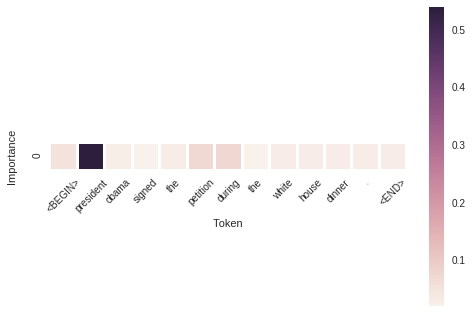

In [458]:
attn_matrix = prediction['attn_scores'].detach().numpy()
ax = sns.heatmap(attn_matrix, linewidths=2, square=True)
tokens = ["<BEGIN>"]+preprocess_text(title).split(" ")+["<END>"]
ax.set_xticklabels(tokens, rotation=45)
ax.set_xlabel("Token")
ax.set_ylabel("Importance\n")
plt.show()

# TODO

- bleu score
- ngram-overlap
- perplexity
- beamsearch
- hierarchical softmax
- hierarchical attention
- Transformer networks